In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/colab_workspace

/content/drive/My Drive/colab_workspace


In [0]:
ls 

 checkpoint.pt      kaggle.json             test_df.csv.zip
 data/              MNIST_data/             torch_submission.csv
 Dig-MNIST.csv      sample_submission.csv   train_df.csv
'kaggle (1).json'   test_df.csv             train_df.csv.zip


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

BATCH_SIZE = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #gpu가있따면 사용, 그렇지않으면 cpu사용
print(device)

cuda


# 1. 데이터 불러오기 및 전처리, Load

In [0]:
df_train = pd.read_csv("train_df.csv")
target = df_train['label']
df_train.drop('label', axis=1, inplace=True)

X_test = pd.read_csv('test_df.csv')

X_test = X_test.iloc[:,1:].values
X_test=pd.DataFrame(X_test) #통일을 위해 다시 데이터프레임화

X_train, X_dev, y_train, y_dev = train_test_split(df_train, target, stratify=target, random_state=42, test_size=0.01)
print('X_train', len(X_train))
print('X_dev', len(X_dev))
print('X_test', len(X_test))

# 2. 시각화

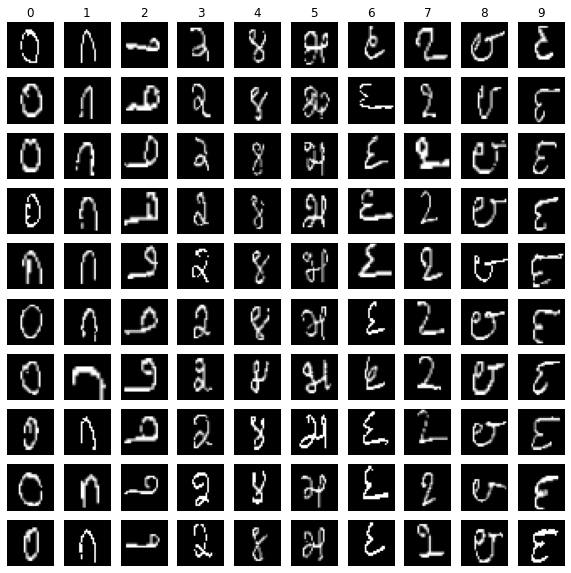

In [0]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))
for i in range(10): # Column by column
    num_i = X_train[y_train == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

# 3. Dataset, Loader 정의
pytorch의 Dataset 클래스를 삽입하는 과정

In [0]:
class CharData(Dataset): #class 삽입   
    def __init__(self,
                 images,
                 labels=None,
                 transform=None,
                ):
        self.X = images
        self.y = labels
        
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = np.array(self.X.iloc[idx, :], dtype='uint8').reshape([28, 28, 1])
        if self.transform is not None:
            img = self.transform(img)
        
        if self.y is not None:
            y = np.zeros(10, dtype='float32')
            y[self.y.iloc[idx]] = 1
            return img, y
        else:
            return img

In [0]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])


In [0]:
#dataset objects 만들기
train_dataset = CharData(X_train, y_train, train_transform)
dev_dataset = CharData(X_dev, y_dev, test_transform)
test_dataset = CharData(X_test, transform=test_transform)

In [0]:
# Batch 적용
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

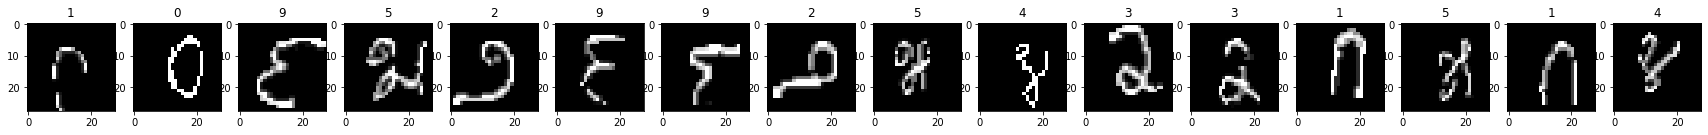

In [0]:
# 샘플확인
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap='gray')
    break

# 4. 모델정의

In [0]:
DEPTH_MULT = 2

class ConvLayer(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3):
        super(ConvLayer, self).__init__()
        self.ops = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.ops(x)


class FCLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCLayer, self).__init__()
        self.ops = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU(inplace=True)
        )
        self.residual = input_size == output_size
    
    def forward(self, x):
        if self.residual:
            return (self.ops(x) + x) / np.sqrt(2)
        return self.ops(x)


def mixup(x, shuffle, lam, i, j):
    if shuffle is not None and lam is not None and i == j:
        x = lam * x + (1 - lam) * x[shuffle]
    return x


class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        
        self.conv1 = ConvLayer(1, DEPTH_MULT * 32)
        self.conv2 = ConvLayer(DEPTH_MULT * 32, DEPTH_MULT * 32)
        self.conv3 = ConvLayer(DEPTH_MULT * 32, DEPTH_MULT * 32)
        self.conv4 = ConvLayer(DEPTH_MULT * 32, DEPTH_MULT * 32)
        
        self.conv5 = ConvLayer(DEPTH_MULT * 32, DEPTH_MULT * 64)
        self.conv6 = ConvLayer(DEPTH_MULT * 64, DEPTH_MULT * 64)
        self.conv7 = ConvLayer(DEPTH_MULT * 64, DEPTH_MULT * 64)
        self.conv8 = ConvLayer(DEPTH_MULT * 64, DEPTH_MULT * 64)
        self.conv9 = ConvLayer(DEPTH_MULT * 64, DEPTH_MULT * 64)
        self.conv10 = ConvLayer(DEPTH_MULT * 64, DEPTH_MULT * 64)
        
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = FCLayer(DEPTH_MULT * 64 * 7 * 7, DEPTH_MULT * 512)
        self.fc2 = FCLayer(DEPTH_MULT * 512, DEPTH_MULT * 512)
        self.fc3 = FCLayer(DEPTH_MULT * 512, DEPTH_MULT * 512)
        self.fc4 = FCLayer(DEPTH_MULT * 512, DEPTH_MULT * 512)
        self.projection = nn.Linear(DEPTH_MULT * 512, 10)
    
    def forward(self, x):
        if isinstance(x, list):
            x, shuffle, lam = x
        else:
            shuffle = None
            lam = None
        
        # Decide which layer to mixup
        j = np.random.randint(15)
        
        x = mixup(x, shuffle, lam, 0, j)
        x = self.conv1(x)
        x = mixup(x, shuffle, lam, 1, j)
        x = self.conv2(x)
        x = mixup(x, shuffle, lam, 2, j)
        x = self.conv3(x)
        x = mixup(x, shuffle, lam, 3, j)
        x = self.conv4(x)
        x = self.mp(x)
        
        x = mixup(x, shuffle, lam, 4, j)
        x = self.conv5(x)
        x = mixup(x, shuffle, lam, 5, j)
        x = self.conv6(x)
        x = mixup(x, shuffle, lam, 6, j)
        x = self.conv7(x)
        x = mixup(x, shuffle, lam, 7, j)
        x = self.conv8(x)
        x = mixup(x, shuffle, lam, 8, j)
        x = self.conv9(x)
        x = mixup(x, shuffle, lam, 9, j)
        x = self.conv10(x)
        x = self.mp(x)
        
        x = x.view(x.size(0), -1)
        x = mixup(x, shuffle, lam, 10, j)
        x = self.fc1(x)
        x = mixup(x, shuffle, lam, 11, j)
        x = self.fc2(x)
        x = mixup(x, shuffle, lam, 12, j)
        x = self.fc3(x)
        x = mixup(x, shuffle, lam, 13, j)
        x = self.fc4(x)
        x = mixup(x, shuffle, lam, 14, j)
        x = self.projection(x)
        
        return x

In [0]:
def criterion(input, target, size_average=True):
    l = -(target * torch.log(F.softmax(input, dim=1) + 1e-10)).sum(1)
    if size_average:
        l = l.mean()
    else:
        l = l.sum()
    return l

In [0]:
model = Net(10)
model = model.to(device)

n_epochs = 100

optimizer = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=n_epochs // 4, gamma=0.1)

# 5.모델 훈련

In [0]:
def train(epoch, history=None):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        # mixup
        alpha = 2
        lam = np.random.beta(alpha, alpha)
        shuffle = torch.randperm(data.shape[0])
        target = lam * target + (1 - lam) * target[shuffle]
        
        optimizer.zero_grad()
        output = model([data, shuffle, lam])
        loss = criterion(output, target)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLR: {:.6f}\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader),
                optimizer.state_dict()['param_groups'][0]['lr'],
                loss.data))
    exp_lr_scheduler.step()

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in dev_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss += criterion(output, target, size_average=False).data

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.max(1, keepdim=True)[1].data.view_as(pred)).cpu().sum().numpy()
    
    loss /= len(dev_loader.dataset)
    accuracy = correct / len(dev_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
        history.loc[epoch, 'dev_accuracy'] = accuracy
    
    print('Dev loss: {:.4f}, Dev accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(dev_loader.dataset),
        100. * accuracy))

In [0]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train(epoch, history)
    evaluate(epoch, history)
    #이미 높은 정확도를 보이고 있기때문에 EarlyStopping 해도 좋을 듯

Train Epoch: 0 [25600/41580 (61%)]	LR: 0.000100	Loss: 1.021838
Dev loss: 0.1099, Dev accuracy: 416/420 (99.048%)

Train Epoch: 1 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.813835
Dev loss: 0.1344, Dev accuracy: 419/420 (99.762%)

Train Epoch: 2 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.691444
Dev loss: 0.1147, Dev accuracy: 416/420 (99.048%)

Train Epoch: 3 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.611507
Dev loss: 0.1211, Dev accuracy: 417/420 (99.286%)

Train Epoch: 4 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.721414
Dev loss: 0.0712, Dev accuracy: 420/420 (100.000%)

Train Epoch: 5 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.384039
Dev loss: 0.0729, Dev accuracy: 418/420 (99.524%)

Train Epoch: 6 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.900925
Dev loss: 0.0719, Dev accuracy: 419/420 (99.762%)

Train Epoch: 7 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.639206
Dev loss: 0.0600, Dev accuracy: 419/420 (99.762%)

Train Epoch: 8 [25600/41580 (61%)]	LR: 0.000100	Loss: 0.655744
Dev loss: 0.0787, Dev ac

# 그래프로 확인

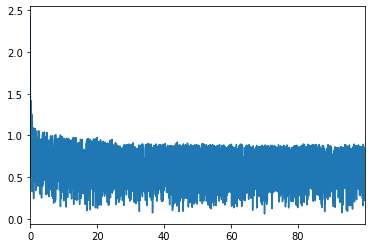

In [0]:
history['train_loss'].plot();

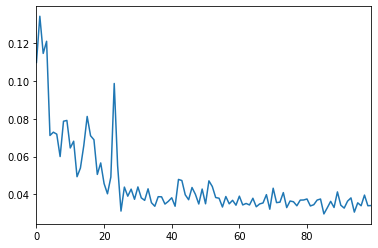

In [0]:
history.dropna()['dev_loss'].plot();

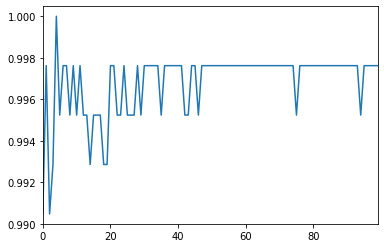

In [0]:
history.dropna()['dev_accuracy'].plot();

In [0]:
print('max', history.dropna()['dev_accuracy'].max())
print('max in last 5', history.dropna()['dev_accuracy'].iloc[-5:].max())
print('avg in last 5', history.dropna()['dev_accuracy'].iloc[-5:].mean())

max 1.0
max in last 5 0.9976190476190476
avg in last 5 0.9976190476190476


# 6.예측 하기 

In [0]:
model.eval()
predictions = []
for data in tqdm(test_loader):
    data = data.to(device)
    output = model(data).max(dim=1)[1] # argmax
    predictions += list(output.data.cpu().numpy())

In [0]:
sample_submission = pd.read_csv("sample_submission.csv") #데이터 불러오기

sample_submission['Category'] = predictions
sample_submission.to_csv('torch_submission.csv', index=False)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8
